In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Decision Tree
from sklearn.tree import DecisionTreeRegressor, plot_tree
# One-hot encoding
from sklearn.preprocessing import OneHotEncoder
# Pipeline
from sklearn.pipeline import Pipeline

In [2]:
raw_data = """Location Shared Apartment Rent
City A True 300
City B False 400
City A True 250
City A True 275
City A False 500
City C True 460
City B False 700
City C False 600"""

In [3]:
data = raw_data.split('\n')
columns = data[0].split()
# Rejoin col 1,2
columns = columns[:1] + [' '.join(columns[1:3])] + columns[3:]
data = [i.split() for i in data[1:]]
# Rejoin data 0,1
data = [[' '.join(i[:2])] + i[2:] for i in data]
df = pd.DataFrame(data, columns=columns)
types = ['category', str, 'int']
for col, t in zip(df.columns, types):
    df[col] = df[col].astype(t)
df[df.columns[1]] = df[df.columns[1]].map({'True':True, 'False':False})
display(df.rename(columns={col:f"{col} ({df[col].dtype})" for col in df.columns}))

,Location (category),Shared Apartment (bool),Rent (int32)
0,City A,True,300
1,City B,False,400
2,City A,True,250
3,City A,True,275
4,City A,False,500
5,City C,True,460
6,City B,False,700
7,City C,False,600


In [4]:
def variance_i_used(switch, key='Location'):
    # Pandas, by default, uses (val-mean)^2/(n-1) for variance
    # this uses (val-mean)^2/n, which may or may not be how we did it in class
    # I don't know, I learned all of this from the internet
    # Should probably check before the exam so (TODO[x])
    # Update: I checked, it's (val-mean)^2/(n-1) in class
    mean_city = df[df[key] == switch]['Rent'].mean()
    var = 0
    for i in df[df[key] == switch]['Rent']:
        var += (i - mean_city)**2
    var = var/df[df[key] == switch].shape[0]
    return var

# Split on Location
# City A
mean_A = df[df['Location'] == 'City A']['Rent'].mean()
var_A = df[df['Location'] == 'City A']['Rent'].var()
var_A_used = variance_i_used('City A')
# City B
mean_B = df[df['Location'] == 'City B']['Rent'].mean()
var_B = df[df['Location'] == 'City B']['Rent'].var()
var_B_used = variance_i_used('City B')
# City C
mean_C = df[df['Location'] == 'City C']['Rent'].mean()
var_C = df[df['Location'] == 'City C']['Rent'].var()
var_C_used = variance_i_used('City C')

# Weighted variance
proportion_A = df[df['Location'] == 'City A'].shape[0]/df.shape[0]
proportion_B = df[df['Location'] == 'City B'].shape[0]/df.shape[0]
proportion_C = df[df['Location'] == 'City C'].shape[0]/df.shape[0]
var_w_total = proportion_A*var_A + proportion_B*var_B + proportion_C*var_C
var_w_total_alt = proportion_A*var_A_used + proportion_B*var_B_used + proportion_C*var_C_used

print(f"City A: mean={mean_A}, var={var_A}, var_used={var_A_used}")
print(f"City B: mean={mean_B}, var={var_B}, var_used={var_B_used}")
print(f"City C: mean={mean_C}, var={var_C}, var_used={var_C_used}")
print(f"Total weighted variance: {var_w_total}, var_w_total_alt={var_w_total_alt}")

# Split on Shared
# Shared
mean_shared = df[df['Shared Apartment'] == True]['Rent'].mean()
var_shared = df[df['Shared Apartment'] == True]['Rent'].var()
var_shared_used = variance_i_used(True, 'Shared Apartment')
# Not Shared
mean_not_shared = df[df['Shared Apartment'] == False]['Rent'].mean()
var_not_shared = df[df['Shared Apartment'] == False]['Rent'].var()
var_not_shared_used = variance_i_used(False, 'Shared Apartment')

# Weighted variance
proportion_shared = df[df['Shared Apartment'] == True].shape[0]/df.shape[0]
proportion_not_shared = df[df['Shared Apartment'] == False].shape[0]/df.shape[0]
var_w_total = proportion_shared*var_shared + proportion_not_shared*var_not_shared
var_w_total_alt = proportion_shared*var_shared_used + proportion_not_shared*var_not_shared_used

print(f"Shared: mean={mean_shared}, var={var_shared}, var_used={var_shared_used}")
print(f"Not Shared: mean={mean_not_shared}, var={var_not_shared}, var_used={var_not_shared_used}")
print(f"Total weighted variance: {var_w_total}, var_w_total_alt={var_w_total_alt}")

City A: mean=331.25, var=13072.916666666666, var_used=9804.6875
City B: mean=550.0, var=45000.0, var_used=22500.0
City C: mean=530.0, var=9800.0, var_used=4900.0
Total weighted variance: 20236.458333333332, var_w_total_alt=11752.34375
Shared: mean=321.25, var=8972.916666666666, var_used=6729.6875
Not Shared: mean=550.0, var=16666.666666666668, var_used=12500.0
Total weighted variance: 12819.791666666668, var_w_total_alt=9614.84375


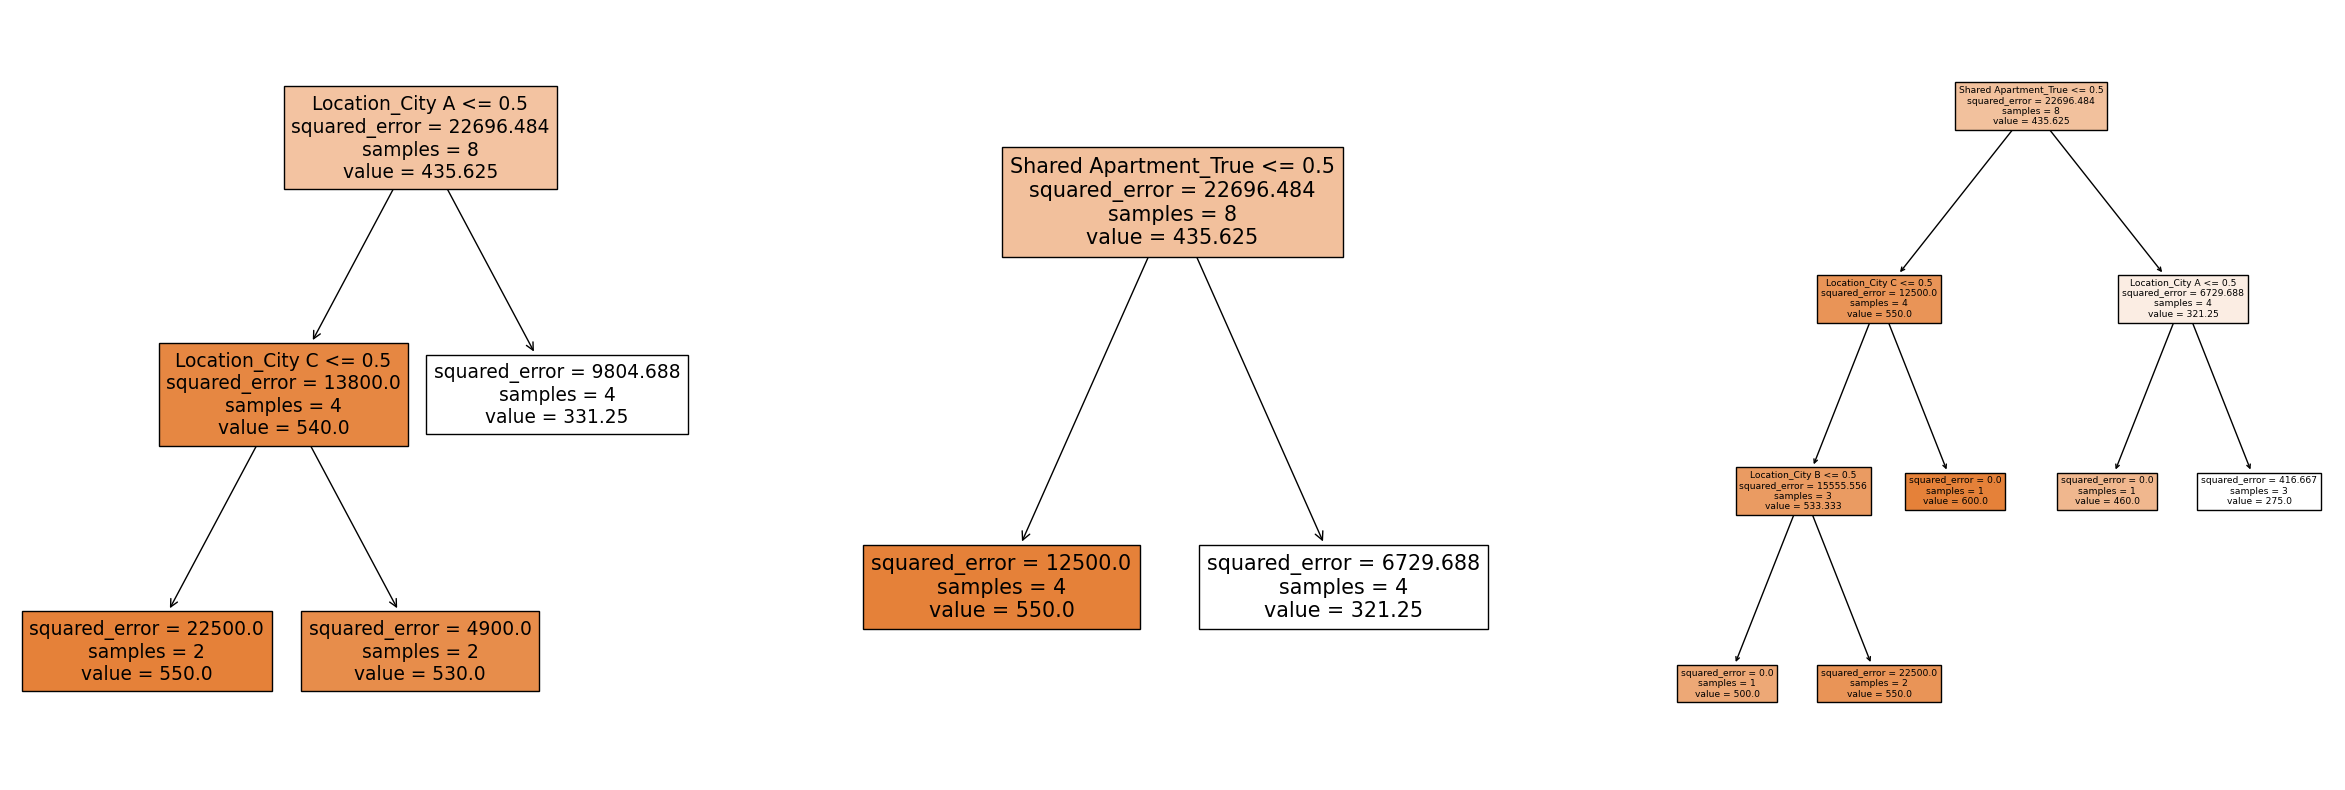

In [5]:
cell_df = df.copy()

ax,f = plt.subplots(figsize=(30,10), ncols=3)
for i,par in enumerate([['Location'], ['Shared Apartment'], ['Location', 'Shared Apartment']]):
    pipe = Pipeline([('onehot', OneHotEncoder(drop='if_binary')), ('tree', DecisionTreeRegressor())])
    pipe.fit(cell_df[par], cell_df['Rent'])
    tree = pipe.named_steps['tree']
    encoder = pipe.named_steps['onehot']
    feature_names = encoder.get_feature_names_out()
    plot_tree(tree, feature_names=feature_names, filled=True, ax=f[i])

